## Analysis of ReAct and LLM-DP Alfworld data

In [2]:
import json

output_dir = "output"
dataset = []

file_to_name = {
    "output/chat_random2_3.json": "llmdp-random",
    # "output/chat_random_3.json": "llmdp-random0",
    # "output/chat_search2_3.json": "llmdp",
    "output/chat_search_nofallback_3.json": "llmdp2",
    "output/react_chat.json": "react-chat",
    "output/llmdp_3.json": "llmdp",
    # "output/react_chat.json": "react-chat-nothink",
    "output/react_text-davinci-002.json": "react-002",
}
order = [
    "llmdp",
    "llmdp2",
    # "llmdp-random0",
    "llmdp-random",
    "react-002",
    "react-chat",
]

for file in file_to_name.keys():
    with open(file, "rb") as f:
        d = json.loads(f.read())
        assert len(d) == 134, f"{file} has {len(d)} examples"
        for i, example in enumerate(d):
            example["file"] = file
            example["n"] = i
        dataset.extend(d)

AssertionError: output/chat_search_nofallback_3.json has 116 examples

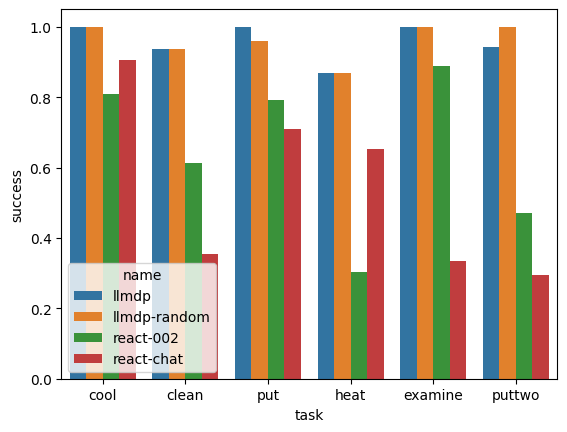

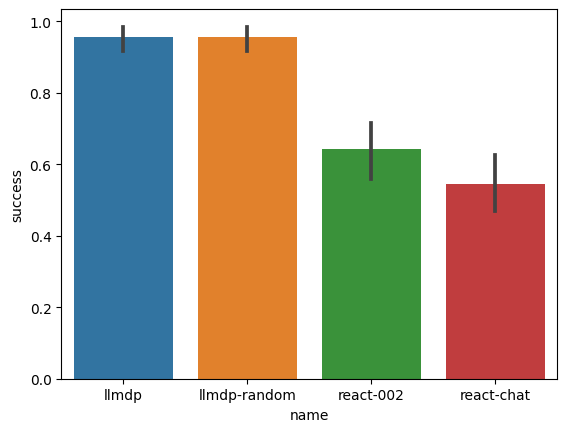

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(dataset)
df["success"] = df["success"].astype(int)
df["name"] = df["file"].apply(lambda x: file_to_name[x])


sns.barplot(x="task", y="success", hue="name", hue_order=order,
              data=df, errwidth=0)
plt.show()

sns.barplot(y="success", x="name", order=order,
            data=df)
plt.show()

In [54]:
df[df["name"] == "llmdp"]

,task,success,length,llm_tokens,file,n,name
268,cool,1,16,5340.0,output/llmdp_3.json,0,llmdp
269,clean,1,16,4524.0,output/llmdp_3.json,1,llmdp
270,clean,1,6,3093.0,output/llmdp_3.json,2,llmdp
271,put,1,11,3083.0,output/llmdp_3.json,3,llmdp
272,clean,1,7,823.0,output/llmdp_3.json,4,llmdp
...,...,...,...,...,...,...,...
397,examine,1,3,1210.0,output/llmdp_3.json,129,llmdp
398,examine,1,17,5904.0,output/llmdp_3.json,130,llmdp
399,heat,1,7,1026.0,output/llmdp_3.json,131,llmdp
400,clean,1,23,9743.0,output/llmdp_3.json,132,llmdp


In [53]:
# Latex table
tmp = df.groupby(["name", "task"]).success.agg(["mean"])
# rotate index
tmp = tmp.unstack().swaplevel(axis=1).sort_index(axis=1, level=0)
tmp.columns = tmp.columns.droplevel(1)
tmp = tmp.reset_index(drop=False)
tmp.name = tmp.name.apply(lambda x: "\\texttt{" + x + "}")

cols =  ["clean", "cool", "examine", "heat", "put", "puttwo"]
tmp["overall"] = df.groupby(["name"]).success.agg(["mean"]).reset_index(drop=False)["mean"]
# format to % all columns except name
tmp = tmp.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)
# tmp.columns = ["name"] + [f"{n} (\%)" for n in tmp.columns if n != "name"] 
print(tmp.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{llllllll}
\toprule
name & clean & cool & examine & heat & put & puttwo & overall \\
\midrule
\texttt{llmdp} & 0.94 & 1.00 & 1.00 & 0.87 & 1.00 & 0.94 & 0.96 \\
\texttt{llmdp-random} & 0.94 & 1.00 & 1.00 & 0.87 & 0.96 & 1.00 & 0.96 \\
\texttt{react-002} & 0.61 & 0.81 & 0.89 & 0.30 & 0.79 & 0.47 & 0.64 \\
\texttt{react-chat} & 0.35 & 0.90 & 0.33 & 0.65 & 0.71 & 0.29 & 0.54 \\
\bottomrule
\end{tabular}



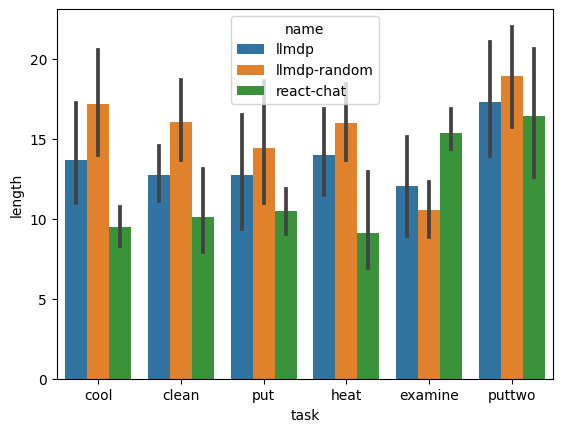

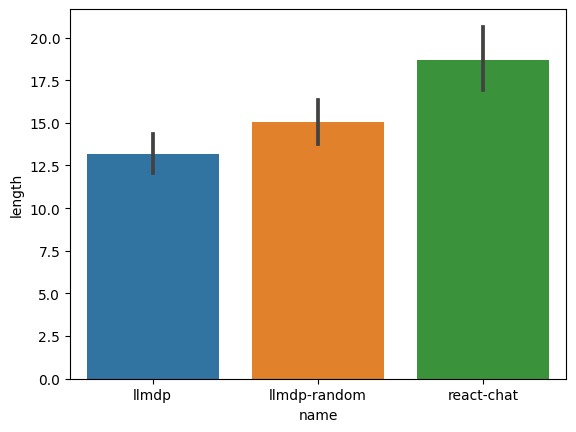

In [56]:
order = ["llmdp", "llmdp-random", "react-chat"]
sns.barplot(x="task", y="length", hue="name", data=df[df.success == 1], hue_order=order)
plt.show()

# sns.barplot(y="length", x="name", order=order,
#               data=df[df.success == 1])
# plt.show()
sns.barplot(y="length", x="name", order=order,
              data=df)
plt.show()

In [70]:
# Latex table
tmp = df.groupby(["name", "task"]).length.agg(["mean"])
# rotate index
tmp = tmp.unstack().swaplevel(axis=1).sort_index(axis=1, level=0)
tmp.columns = tmp.columns.droplevel(1)
tmp = tmp.reset_index(drop=False)
tmp.name = tmp.name.apply(lambda x: "\\texttt{" + x + "}")

cols =  ["clean", "cool", "examine", "heat", "put", "puttwo"]
tmp["overall"] = df.groupby(["name"]).length.agg(["mean"]).reset_index(drop=False)["mean"]
# format to % all columns except name
tmp = tmp.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)
tmp.columns = ["name"] + [f"{n}" for n in tmp.columns if n != "name"] 
print(tmp.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{llllllll}
\toprule
name & clean & cool & examine & heat & put & puttwo & overall \\
\midrule
\texttt{llmdp} & 12.00 & 13.67 & 12.06 & 12.30 & 12.75 & 17.59 & 13.16 \\
\texttt{llmdp-random} & 15.06 & 17.14 & 10.56 & 14.04 & 14.62 & 18.94 & 15.02 \\
\texttt{react-002} & 27.55 & 18.14 & 23.44 & 37.70 & 25.75 & 38.00 & 28.27 \\
\texttt{react-chat} & 25.10 & 9.86 & 21.67 & 14.70 & 15.33 & 24.94 & 18.69 \\
\bottomrule
\end{tabular}



### Token Counts

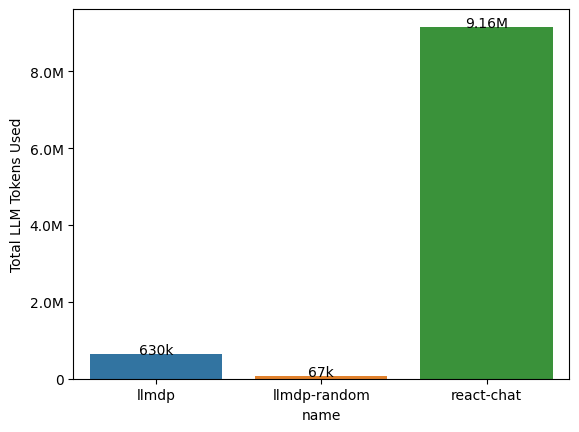

,name,llm_tokens
0,llmdp,630427.0
1,llmdp-random,67113.0
2,react-002,4664079.0
3,react-chat,9160627.0


In [69]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def format_y_ticks(value, _):
    if value >= 1_000_000:
        r = (value % 1_000_000)/10000
        return f"{int(value/1_000_000)}.{int(r)}M"
    elif value >= 1_000:
        return f"{int(value/1_000)}k"
    else:
        return int(value)
    
# chart: sum of tokens
sns.barplot(y="llm_tokens", 
            x="name",
            estimator=sum,
            data=df[df.name.isin(order)].groupby("name").sum()["llm_tokens"].reset_index(),
            order=order
            )
plt.ylabel("Total LLM Tokens Used")

new_df = df.groupby("name").sum()["llm_tokens"].reset_index()
for i, name in enumerate(order):
    y = new_df[new_df.name == name].iloc[0].llm_tokens
    c = format_y_ticks(y, None)
    plt.text(i, y, f"{c}", color='black', ha="center")

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
plt.show()